In [18]:
import timm
import torch
from PIL import Image
import numpy as np

# %load "../segmentation.py"
import numpy as np
import cv2
from PIL import Image
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils
from torch.autograd import Variable
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import os
import glob
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as transforms
import torch

from sklearn.model_selection import train_test_split
from PIL import Image
from torch.utils.data import Dataset

torch.manual_seed(0)

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

# Device
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [19]:
def image_colorfulness(image):
	# split the image into its respective RGB components
	(B, G, R) = cv2.split(image.astype("float"))
	# compute rg = R - G
	rg = np.absolute(R - G)
	# compute yb = 0.5 * (R + G) - B
	yb = np.absolute(0.5 * (R + G) - B)
	# compute the mean and standard deviation of both `rg` and `yb`
	(rbMean, rbStd) = (np.mean(rg), np.std(rg))
	(ybMean, ybStd) = (np.mean(yb), np.std(yb))
	# combine the mean and standard deviations
	stdRoot = np.sqrt((rbStd ** 2) + (ybStd ** 2))
	meanRoot = np.sqrt((rbMean ** 2) + (ybMean ** 2))
	# derive the "colorfulness" metric and return it
	return stdRoot + (0.3 * meanRoot)

In [20]:
def get_ratio(image):
    h, w, _ = image.shape
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU + cv2.THRESH_BINARY_INV)[1]

    pixels = cv2.countNonZero(thresh)
    ratio = (pixels/(h * w)) * 100
    return ratio

In [21]:
# Automatic brightness and contrast optimization with optional histogram clipping
def automatic_brightness_and_contrast(image, clip_hist_percent=1):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Calculate grayscale histogram
    hist = cv2.calcHist([gray],[0],None,[256],[0,256])
    hist_size = len(hist)
    
    # Calculate cumulative distribution from the histogram
    accumulator = []
    accumulator.append(float(hist[0]))
    for index in range(1, hist_size):
        accumulator.append(accumulator[index -1] + float(hist[index]))
    
    # Locate points to clip
    maximum = accumulator[-1]
    clip_hist_percent *= (maximum/100.0)
    clip_hist_percent /= 2.0
    
    # Locate left cut
    minimum_gray = 0
    while accumulator[minimum_gray] < clip_hist_percent:
        minimum_gray += 1
    
    # Locate right cut
    maximum_gray = hist_size -1
    while accumulator[maximum_gray] >= (maximum - clip_hist_percent):
        maximum_gray -= 1
    
    # Calculate alpha and beta values
    alpha = 255 / (maximum_gray - minimum_gray)
    beta = -minimum_gray * alpha
    
    '''
    # Calculate new histogram with desired range and show histogram 
    new_hist = cv2.calcHist([gray],[0],None,[256],[minimum_gray,maximum_gray])
    plt.plot(hist)
    plt.plot(new_hist)
    plt.xlim([0,256])
    plt.show()
    '''

    auto_result = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return auto_result

100%|██████████| 1799/1799 [00:53<00:00, 33.47it/s]


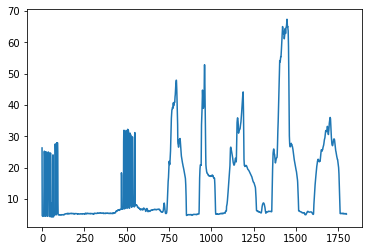

100%|██████████| 1499/1499 [00:59<00:00, 25.34it/s]


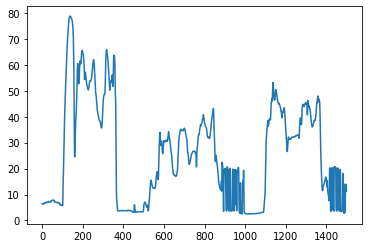

100%|██████████| 3642/3642 [02:24<00:00, 25.14it/s]


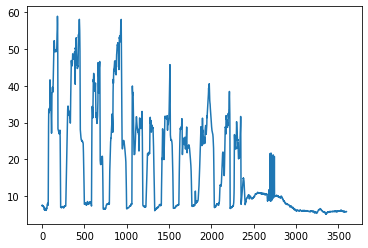

100%|██████████| 2123/2123 [01:30<00:00, 23.52it/s]


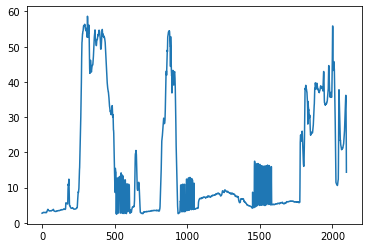

100%|██████████| 1547/1547 [01:02<00:00, 24.83it/s]


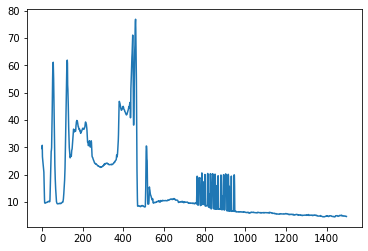

In [22]:
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt 

video_location = "../test-videos/"
videos = ["testA_1.mp4","testA_2.mp4","testA_3.mp4","testA_4.mp4","testA_5.mp4",]
images_list = []
ratios_list = []
colors_list = []
metrics_list = []

for video in videos:
  vidcap = cv2.VideoCapture(video_location+video)
  fps = vidcap.get(cv2.CAP_PROP_FPS)      
  frame_count = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
  resized_image = []

  for i in tqdm(range(frame_count)):
    try:
      success,image = vidcap.read()
      image = image[256:896, 512:1400]
      image = automatic_brightness_and_contrast(image)
      image = cv2.resize(image, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
      resized_image.append(image)
    except:
      pass
  ratios = []
  colors = []
  metrics = []
  for img in resized_image:
    # ratio = get_ratio(img)
    color = image_colorfulness(img)
    # metric = color*color*ratio
    colors.append(color)
    # ratios.append(ratio)
    # metrics.append(metric)
  
  images_list.append(resized_image)
  # ratios_list.append(ratios)
  colors_list.append(colors)
  # metrics_list.append(metrics)
  # print(video)
  # plt.plot(metrics)
  # plt.show()
  # plt.plot(ratios)
  # plt.show()
  plt.plot(colors)
  plt.show()

In [23]:
import scipy.fftpack as fftpack

def get_sharpness(image):
    im = Image.fromarray(image).convert('L') # to grayscale
    array = np.asarray(im, dtype=np.int32)

    gy, gx = np.gradient(array)
    gnorm = np.sqrt(gx**2 + gy**2)
    sharpness = np.average(gnorm)
    return sharpness

def smooth_data_fft(arr, span):  # the scaling of "span" is open to suggestions
    w = fftpack.rfft(arr)
    spectrum = w ** 2
    cutoff_idx = spectrum < (spectrum.max() * (1 - np.exp(-span / 2000)))
    w[cutoff_idx] = 0
    return fftpack.irfft(w)

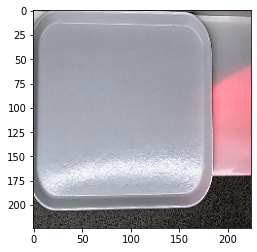

Color 8.167794706454442
Sharp 7.758936635912827
Metric 113.23455961031982


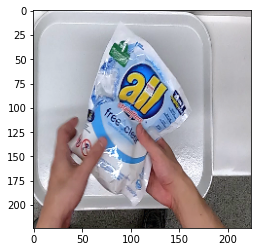

Color 29.13930656799327
Sharp 5.359846038024125
Metric 220.0345393418451


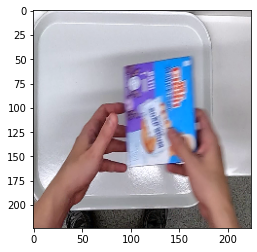

Color 17.37923845777346
Sharp 6.157916597694609
Metric 303.1054478990398


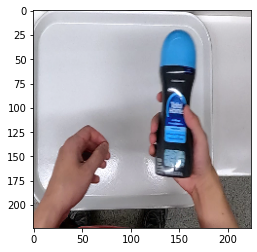

Color 20.703031847212078
Sharp 5.803714095366864
Metric 214.80745169196868


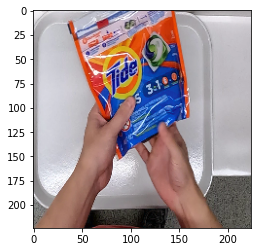

Color 66.53294263546601
Sharp 10.862756221967894
Metric 401.5351879464278


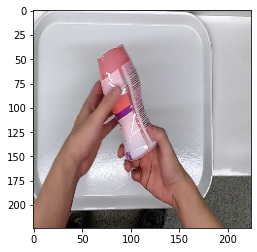

Color 27.788495129810283
Sharp 4.558660953067654
Metric 178.2558377704663


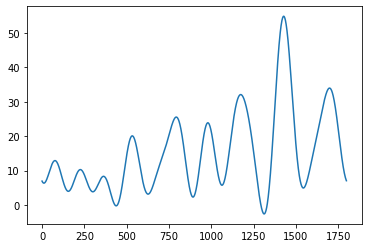

NEXT


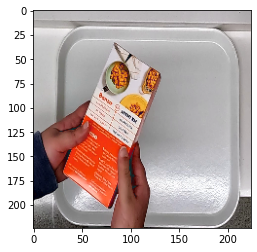

Color 58.6650315244048
Sharp 8.495381022934007
Metric 300.7602028597883


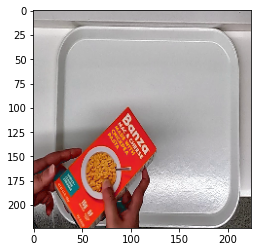

Color 57.06253330011554
Sharp 9.341683957588433
Metric 300.1040631249378


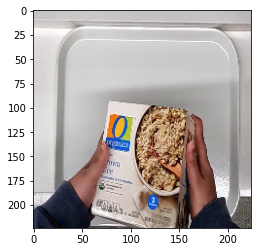

Color 32.4150072662661
Sharp 8.758125808710554
Metric 169.1987977122839


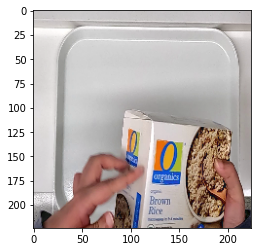

Color 37.20221309160417
Sharp 9.211830008376468
Metric 192.50823310671058


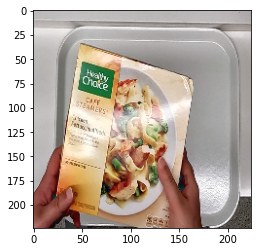

Color 32.14958970053343
Sharp 9.093439607798159
Metric 218.43469727390624


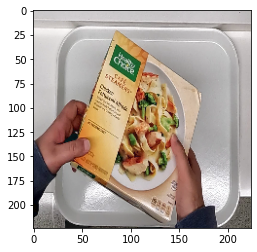

Color 36.27882475933754
Sharp 9.356004484413573
Metric 222.88275001004553


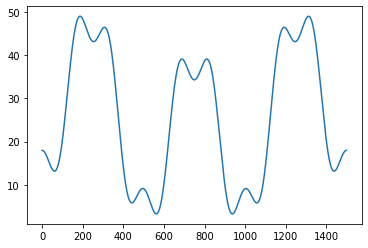

NEXT


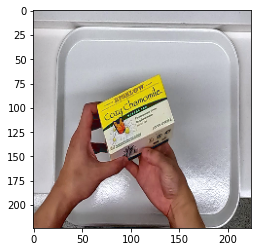

Color 49.70163319059818
Sharp 8.894768848231207
Metric 262.83068809033153


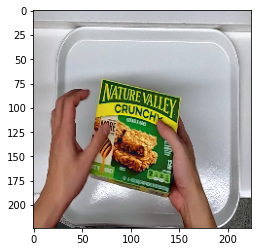

Color 52.36643537888024
Sharp 8.354104577220241
Metric 299.0860197045011


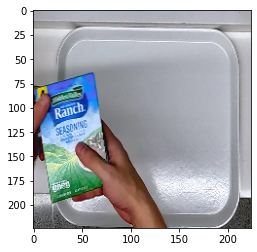

Color 29.785051990603332
Sharp 9.291988342794498
Metric 226.2003439104885


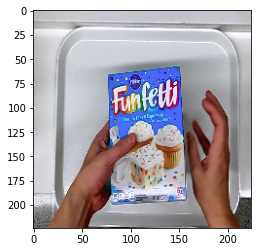

Color 50.02799835269872
Sharp 11.811266453418218
Metric 315.6491541646558


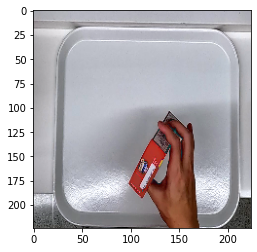

Color 29.082355353470035
Sharp 8.092761001023947
Metric 147.61498026331046


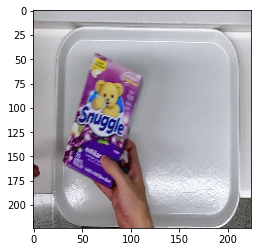

Color 31.023700077345566
Sharp 10.444256330592799
Metric 144.90742056908022


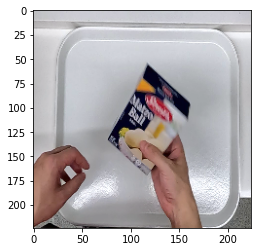

Color 23.852358754191037
Sharp 6.711984770851108
Metric 112.55339250780509


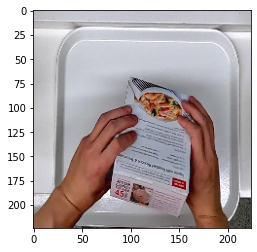

Color 36.11324991521826
Sharp 7.927698710257228
Metric 202.7050730347433


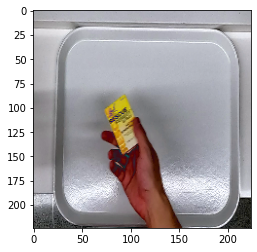

Color 19.67934166957684
Sharp 7.027205460225547
Metric 181.1861210266001


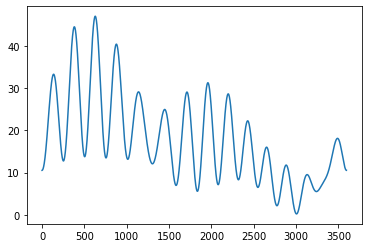

NEXT


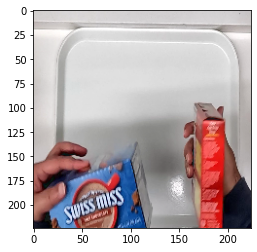

Color 49.781722051384584
Sharp 6.163950870408129
Metric 324.4646469578415


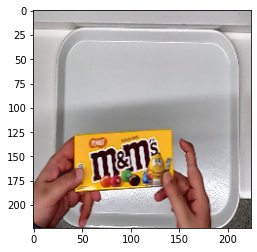

Color 41.68641216360167
Sharp 7.460885971124898
Metric 242.14225008887107


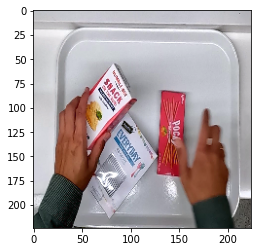

Color 44.89969456739553
Sharp 9.696438952377727
Metric 231.20991650624592


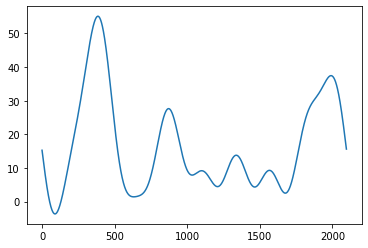

NEXT


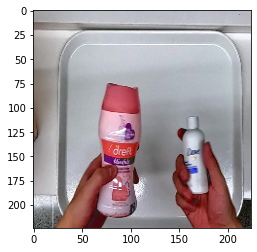

Color 38.374460392497426
Sharp 9.688204591705077
Metric 231.43257423227413


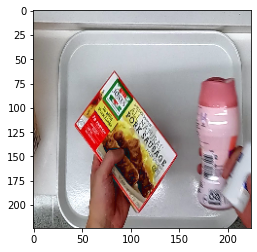

Color 48.79854454834591
Sharp 6.622725880258622
Metric 285.84175687929945


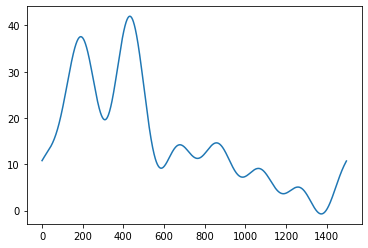

NEXT


In [29]:
from scipy.signal import savgol_filter, argrelextrema,find_peaks
import math
images_with_object = []

count = 1
for images, colors in zip(images_list, colors_list):
    frames_with_object = []
    rolling_colors = smooth_data_fft(colors, 20)
    maximas = find_peaks(rolling_colors)
    for maxima in maximas[0]:
        candidate_frame = maxima
        max_sharpness = -1
        max_metric = -1
        for i in range(-21,22,7):
            current_frame = maxima+i
            if(current_frame>=len(images)):
                continue
            sharpness = get_sharpness(images[current_frame])
            colorfulness = image_colorfulness(images[current_frame])
            ratio = get_ratio(images[current_frame])
            metric = colorfulness*colorfulness * ratio
            metric = math.sqrt(metric)
            if(sharpness>max_sharpness and metric>max_metric):
                max_sharpness = sharpness
                max_metric = metric
                candidate_frame = current_frame
        if(max_metric>110):
            frames_with_object.append((images[candidate_frame],candidate_frame))
            count+=1
            plt.imshow(images[candidate_frame][:,:,[2,1,0]])
            plt.show()

            print(f"Color {colorfulness}")
            print(f"Sharp {sharpness}")
            print(f"Metric {max_metric}")

    plt.plot(rolling_colors)
    plt.show()
    print("NEXT")
    images_with_object.append(frames_with_object)